# Загрузка Order book из CSV

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [2]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [3]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-09-23'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [4]:
df_history.shape

(2492909, 11)

In [5]:
df_history.sort_values('dt').tail()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-10-16 19:08:33,11483372.0,19,binance,ETH/USDT,213.169998,4.12098,None,sell,39448601.0,memory,2018-10-16 19:08:35.5100000
2018-10-16 19:08:34,11483373.0,19,binance,ETH/USDT,213.240005,0.00004,None,buy,39448602.0,memory,2018-10-16 19:08:35.5100000
2018-10-16 19:08:35,11483378.0,19,binance,ETH/USDT,213.169998,0.43599,None,sell,39448603.0,memory,2018-10-16 19:08:38.2833333
2018-10-16 19:08:35,11483379.0,19,binance,ETH/USDT,213.240005,1.07651,None,buy,39448604.0,memory,2018-10-16 19:08:38.2833333
2018-10-16 19:08:36,11483380.0,19,binance,ETH/USDT,213.169998,0.56299,None,sell,39448605.0,memory,2018-10-16 19:08:38.2833333


In [8]:
# # #перевод в нужные интервалы
# interval = 60 # minutes

# df = df_history[['price', 'amount']].resample(str(interval)+'min').ohlc()
# hist = df_history[['price', 'amount']].resample(str(interval)+'min').mean()
# # hist.shape

In [11]:
plt.rcParams['figure.figsize'] = [16, 9]

In [31]:
mylist=[]
lag_no = 1 #номер лага, по которому мы хотим найти наиболее подходящий временной промежуток

print('расчет для лага =', lag_no)

for i in range(1,1000):
    h = df_history[['price']].resample(str(i)+'min').mean()
    a = acf(h[0:len(h)].price.diff().dropna(), nlags=lag_no)[lag_no]
    mylist.append(a)
    #print(i,a)

# то же самое через comprehension
#mylist=[acf(df_history[['price']].resample(str(i)+'min').mean()[0:len(df_history[['price']].resample(str(i)+'min'))].price.diff().dropna(),nlags=2)[2] for i in range(1,120)]

расчет для лага = 1


In [32]:
corr_lag = pd.DataFrame(mylist, columns=['autocorrelations'])

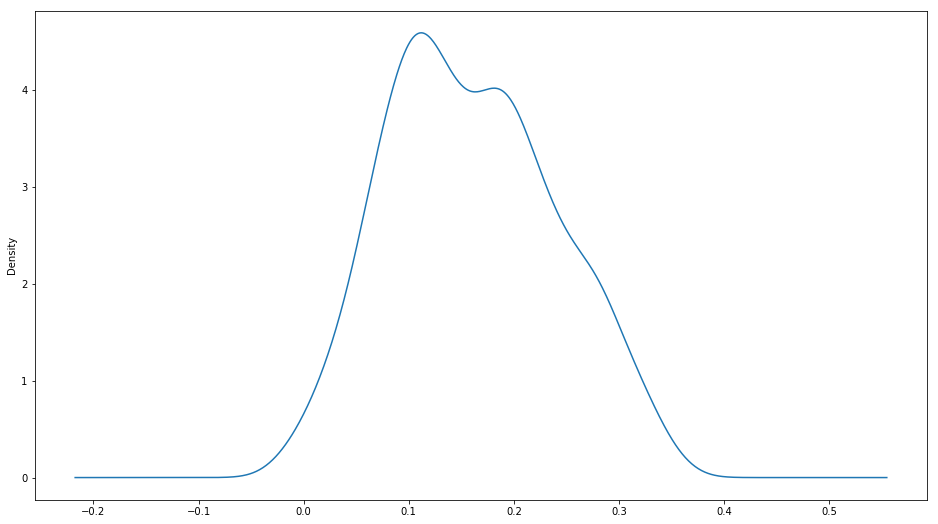

In [33]:
_=corr_lag.autocorrelations.plot(kind='kde')

In [34]:
#рекомендованный временной интервал для группировки datetime

print ('расчет для лага =', lag_no)
corr_lag.autocorrelations.sort_values(ascending=False).head(30)

расчет для лага = 1


977    0.361822
733    0.355807
949    0.353232
750    0.347963
978    0.344776
28     0.342420
950    0.340112
734    0.340106
948    0.339407
751    0.337038
951    0.332519
827    0.331378
979    0.329059
873    0.328905
874    0.328792
38     0.327187
875    0.325848
952    0.325690
953    0.324107
872    0.323887
31     0.323551
689    0.323387
752    0.321249
876    0.321171
690    0.320909
954    0.319735
903    0.319133
976    0.317285
32     0.315424
877    0.313745
Name: autocorrelations, dtype: float64